# Simplfied version : No rising and falling effect

In [197]:
# 1 ns unit for time
# parameters based on expected parameter of cQEDMLv17A3/A4
%matplotlib inline
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import plots
from qutip import *
from scipy.special import erf

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34*1e-9  # reduced Planck constant
All = 'all'
options = Options()

In [211]:
Nq = 2  # number of levels in qubit
N1 = 10  # number of levels in resonator 1
N2 = 10  # number of levels in resonator 2

wq = 7*2*pi  # qubit frequency
wp = wq  # pump frequency
w1 = wq  # resonator 1 frequency
w2 = wq  # resonator 2 frequency

kq = 2*pi*0.00000155  # photon emission frequency of qubit (qubit decay rate)
k1 = 2*pi*0.000015   # photon emission freqency of resonator 1 (resonator 1 decay rate)
k2 = 2*pi*0.01   # photon emission frequency of resonator 2 (resonator 2 decay rate)

g1 = 2*pi*0.0005  # drive frequency resonator 1, coupling between qubit and resonator 1
g2 = 2*pi*0.0030  # drive frequency resonator 2, coupling between qubit and resonator 2
chi1 = 25.e-6*2*pi # dispersive-coupling between qubit and resonator1.
chi2 = 0.7e-3*2*pi # dispersive-coupling between qubit and resonator2.

Ec = 0.2*2*pi  # Anharmonicity

In [212]:
t0 = 0            # start Gaussian pulse Omega
t1 = t0 + 40   # end Gaussian pulse Omega
t2 = t1 + 10   # start square pulse at resonator 1
t3 = t2 + 120  # end square pulse at resonator 1
t4 = t3 + 10   # start square pulse at resonator 2
t5 = t4 + 370  # end square pulse at resonator 2
t6 = t5 + 10   # t0
tg = 10        # Gaussian rise and fall time of square pulse

N_repeat = 3  # number of times to repeat cycle
Np = 1000     # number of discrete time steps per cycle for which to store the output
Q = 2  # number of std's in Gaussian curves, rises and falls

In [213]:
# Convention:
# [qubit, resonator 1]

# Qubit operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
nq = b.dag()*b
sx = tensor(fock_dm(Nq, 0), qeye(N1), qeye(N2)) # x-projection of qubit level
sy = tensor(fock_dm(Nq, 1), qeye(N1), qeye(N2)) # y-projection of qubit level
sz = tensor(fock_dm(Nq, 2%Nq), qeye(N1), qeye(N2)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))
n1 = a1.dag()*a1
n2 = a2.dag()*a2

# Jaynes-Cummings Hamiltonian
Hjc = ( (w1-wq)*(w1*a1.dag()*a1) 
      - Ec/2*b.dag()*b.dag()*b*b )+chi2*nq*a2.dag()*a2+chi1*nq*(a1.dag()*a1)

# Coupling Hamiltonians
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a2*b.dag() + b*a2.dag())

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Q"  : Q}

In [214]:
def pump_strength(args):
    t0 = args['t0']
    t1 = args['t1']
    Q  = args['Q']
    tau = t1-t0      # pulse duration
    std = tau/(2*Q)  # standard deviation
    time = lambda t : t/(std*sqrt(2))  # t' to pass to error function
    
    """
    TODO: include qubit decay rate kq
    """
    
    integral = sqrt(2*pi)*std*erf(time(tau)/2)
    Omega = pi*0.5/integral
    return Omega

# Pump Hamiltonian
Omega = pump_strength(H_args)
H_args['Omega'] = Omega
Hp = 1*Omega/2*(b + b.dag())  # including rotating frame approximation

In [215]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c2 = sqrt(k2)*a2  # resonator 2
# c_ops = [cq, c1, c2]
c_ops = [cq,c1,c2]


# Expectation operators
e_ops = [nq, n1, n2, sx, sy, sz]

In [216]:
def pump(t, args):
    t0 = args['t0']  # start of pulse
    t1 = args['t1']  # end of pulse
    Q  = args['Q']
    
    t = t%t6  # repeat cycle
    mu = (t1-t0)/2  # pulse center in time domain
    std = (t1-t0)/(2*Q)  # standard deviation
    confine = np.heaviside((t-t0), 0) - np.heaviside((t-t1), 0)  # entire pulse
    
    pulse = exp(-(t-mu)**2/(2*std**2))*confine
    return pulse

In [217]:
def square1(t, args):
    t2 = args['t2']  # start of pulse
    t3 = args['t3']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    Q  = args['Q']
    
    t = t%t6  # repeat cycle
    confine = np.heaviside((t-t2), 0) - np.heaviside((t-t3), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : exp(-(t-mu)**2/(2*std**2))  # Gaussian
    
    block = np.heaviside((t-(t2+tg)), 0) - np.heaviside((t-(t3-tg)), 0)
    rise = gauss(t2+tg) * (1-np.heaviside((t-(t2+tg)), 0))
    fall = gauss(t3-tg) * (np.heaviside((t-(t3-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

In [218]:
def square2(t, args):
    t4 = args['t4']  # start of pulse
    t5 = args['t5']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    g2 = args['g2']  # pulse strength
    Q  = args['Q']
    
    t = t%t6  # repeat cycle
    confine = np.heaviside((t-t4), 0) - np.heaviside((t-t5), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : exp(-(t-mu)**2/(2*std**2))  # Gaussian
    
    block = np.heaviside((t-(t4+tg)), 0) - np.heaviside((t-(t5-tg)), 0)
    rise = gauss(t4+tg) * (1-np.heaviside((t-(t4+tg)), 0))
    fall = gauss(t5-tg) * (np.heaviside((t-(t5-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

In [219]:
H = [Hjc, [Hp, pump], [H1, square1], [H2, square2]]  # complete Hamiltonian
tlist = np.linspace(0, N_repeat*t6, N_repeat*Np)  # discrete time steps for which to store the output
psi0 = tensor(basis(Nq,0), basis(N1,0), basis(N2,0))  # initial state

# options=Options()
# options.nsteps=3000
# options.rtol=10**(-9)
# options.store_states=True
# options.max_step=0.1

options.method = 'bdf'
# options.nsteps = 1e5  # max number of steps to take for each interval
options.rtol = 1e-9
# options.max_step = 0.1
options.store_states=True
options.order=5

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

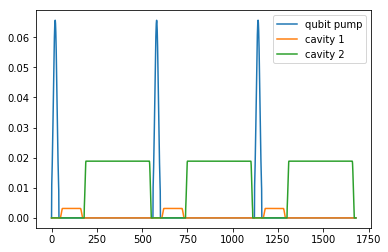

In [220]:
pump_pulse = Omega*pump(tlist, H_args)
sqr1_pulse = g1*square1(tlist, H_args)
sqr2_pulse = g2*square2(tlist, H_args)
plt.plot(tlist, pump_pulse, label='qubit pump')
plt.plot(tlist, sqr1_pulse, label='cavity 1')
plt.plot(tlist, sqr2_pulse, label='cavity 2')
# plt.ylim(0,0.04)
# plt.xlim(1000,1200)
plt.legend()

Text(0,0.5,'$n_q$')

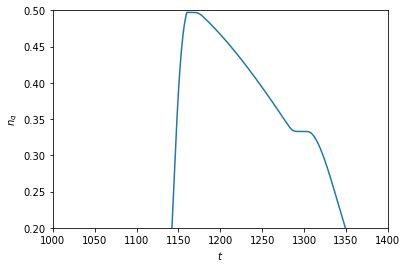

In [221]:
obj = 2    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = 200  # index of tlist

plt.plot(tlist, result.expect[0])
plt.ylim(0.2,.5)
plt.xlim(1000,1400)
plt.xlabel("$t$")
plt.ylabel("$n_q$")
# cont = plots.wigner(result.states, obj=obj, ind=ind)
# plots.dmat_hinton(result.states, obj=obj, ind=ind)
# plots.dmat_his t(result.states, obj=obj, ind=ind)

Text(0,0.5,'$n_q$')

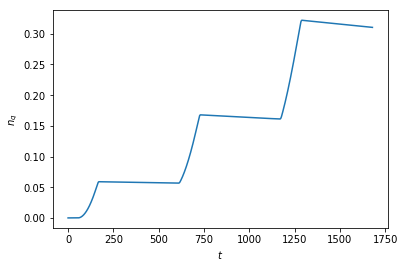

In [222]:
obj = 0    # 0 =5 qubit, 1 = cavity 1, 2 = cavity 2
ind = 200  # index of tlist

plt.plot(tlist, result.expect[1])
plt.xlabel("$t$")
plt.ylabel("$n_q$")
# cont = plots.wigner(result.states, obj=obj, ind=ind)
# plots.dmat_hinton(result.states, obj=obj, ind=ind)
# plots.dmat_hist(result.states, obj=obj, ind=ind)

In [223]:
print(result.expect[1][310])    
print(result.expect[1][1310])
print(result.expect[1][2310])  
print((result.expect[1][1310]-result.expect[1][310])/result.expect[1][310])
print((result.expect[1][2310]-result.expect[1][1310])/result.expect[1][310])

0.05894605569053565
0.16786099246666938
0.32195315145164705
1.8477052535615384
2.6141216266268117
